# **Intro to Pytorch and Tensorboard** 

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline


## Data load

All dataset classes are subclasses of [`torch.util.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) have `__getitem__` and `__len__` methods implemented. Thus, it can be passed to a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), which can load multiple samples parallelly.
Popular Dataset subclasses:

- [MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)
- [Fashion-MNIST](https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist)
- [CIFAR](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)
- [CelebA](https://pytorch.org/docs/stable/torchvision/datasets.html#celeba)

`MNIST` constructor signature: `torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)`, where `transform` - function/transform that takes in an PIL (Height x Width x Channels) image and returns a transformed version. 

**Several transformations can be combined together. Popular transformations**:
- `torchvision.transforms.Normalize(mean, std, inplace=False)`
- `torchvision.transforms.ToTensor()` - Converts a PIL Image or `numpy.ndarray` (H x W x C) in the range `[0, 255]` to a `torch.FloatTensor` of shape (C x H x W) in the range `[0.0, 1.0]` 


DataLoader constructor signature
`torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None)`, where
- dataset is DataSet instance
- batch_size - number of items sampled at every iteration
- num_workers - number of simultaneous reading processes (**NB** on Windows you might want to set it to `0`)

DataLoaders provide convenient interface for training loops: 

```python
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            ...
            
```
or 
```python
    batch_X, batch_y = iter(trainloader).next()
```

In [4]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # normalize around 0.5 with std 0.5
]) # Transforms data to tensor. ('numpy array' or 'PIL image' --> Tensor)

ds_train = datasets.MNIST("~/share/data/", train=True, download=True, transform=transform)
ds_test = datasets.MNIST("~/share/data/", train=False, download=True, transform=transform)

/home/mohammadreza/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
#dataloader: Allows you wrap an iterable around the Dataset instance, to enable 
# easy access to the sample. here we have 512 batch per an iteration.
# briefly, it take sample form our Dataset, here is MNIST
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=512,
                                           shuffle=True, num_workers=2)
# batch_size = number of objects per iteration

test_loader = torch.utils.data.DataLoader(ds_test, batch_size=1000, 
                                          shuffle=False, num_workers=2)

In [7]:
print('Train:', ds_train, "\nTest:", ds_test)

Train: Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/mohammadreza/share/data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) 
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/mohammadreza/share/data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [8]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

**Get sample out of the train loader**  
it gives you couple of data ---→ ***X_batch*** & ***y_batch***

In [9]:
X_batch, y_batch = iter(train_loader).next() # The next() function returns the 
# next item in an iterator. 1 iteration = 512 sample

print('batch size:', len(X_batch), "batch_dimension", X_batch.shape)

batch size: 512 batch_dimension torch.Size([512, 1, 28, 28])


The output is torch tensor

In [10]:
type(X_batch), type(ds_train)

(torch.Tensor, torchvision.datasets.mnist.MNIST)

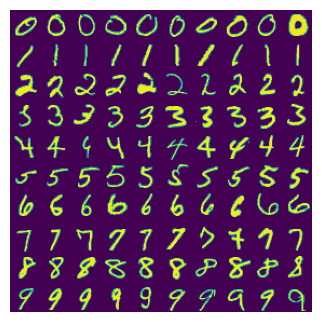

In [11]:
plt.figure(figsize=(4, 4), dpi=100)
plt.axis('off')

plt.imshow(
    torch.transpose(
        torch.cat(
            [X_batch[y_batch == c][:10] for c in range(10)], axis=0
        ).reshape(10, 10, 28, 28),
        1, 2
    ).reshape(280, 280)
)
plt.show()

## Automatic differentiation
Automatic differentiaion is the main mechanism for the backpropagation in PyTorch. PyTorch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` context:

```
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```
Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [12]:
x = torch.randn(2, 2, requires_grad=True) # 2*2 matrix, initialized with random number
print(x)

tensor([[ 0.7647,  1.8982],
        [-0.9285, -0.2450]], requires_grad=True)


In [13]:
# operation on x  
y = x ** 2
y1 = torch.sqrt(x) * torch.sin(2 * x)
print(y, y1)

tensor([[0.5848, 3.6032],
        [0.8622, 0.0600]], grad_fn=<PowBackward0>) tensor([[ 0.8737, -0.8391],
        [    nan,     nan]], grad_fn=<MulBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [14]:
## grad_fn shows the function that generated this variable y
print('Operation on x in y1 is : ', y1.grad_fn)
print('---'*10)
print('Operation on x in y is : ', y.grad_fn)

Operation on x in y1 is :  <MulBackward0 object at 0x7f3ee6f2ff70>
------------------------------
Operation on x in y is :  <PowBackward0 object at 0x7f3ee6f2ff70>


Till now, `autograd` has kept track of the operators on x, which is `<PowBackward0`. Pytorch would not compute the gradient unless you use `backward()` function.

In [15]:
print(x.grad)

None


Sine we have not computed any gradient of y with respect to x

In [16]:
#y.backward()

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. In order to get rid of this error, Let's reduce the tensor `y` to a scalar value, the mean.

To calculate the gradients, you need to run the `.backward` method on a variable `z`, for example. This will calculate the gradient for `z` with respect to `x`

$$\frac{\partial z}{\partial x}=\frac{\partial}{\partial x}\left[\frac{1}{n} \sum_{i}^{n} x_{i}^{2}\right]=\frac{x}{2}$$


In [17]:
z = y.mean() # sum(1/4 (x ** 2))
print('z = ', z, '\n','---'*15)
z.backward() #1/4 ( d/dx x ** 2)
print(x.grad)
print('---'*15, '\nx/2 =', x/2)

z =  tensor(1.2775, grad_fn=<MeanBackward0>) 
 ---------------------------------------------
tensor([[ 0.3824,  0.9491],
        [-0.4643, -0.1225]])
--------------------------------------------- 
x/2 = tensor([[ 0.3824,  0.9491],
        [-0.4643, -0.1225]], grad_fn=<DivBackward0>)


In [18]:
print(x)

tensor([[ 0.7647,  1.8982],
        [-0.9285, -0.2450]], requires_grad=True)


In [19]:
print(y)

tensor([[0.5848, 3.6032],
        [0.8622, 0.0600]], grad_fn=<PowBackward0>)


In [20]:
0.9129/4 + 0.149/4 + 0.9854/4 + 0.0194/4

0.516675

***

Deep learning requires rapid calculation. Fortunately, Pytorch supports GPU acceleration. First, you have to check if your graphic card supports CUDA. for install and more details see [here](https://developer.nvidia.com/cuda-downloads).  
Below, we define a function to choose a cuda randomly. 

In [21]:
import torch
print(torch.__version__)# Get PyTorch and CUDA version
#torch.cuda.is_available() # Check that CUDA works
torch.cuda.device_count() # Check how many CUDA capable devices you have

1.9.0+cu102


1

In [31]:
def get_random_gpu():
    return np.random.randint(2)

def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

In [32]:
get_random_gpu()

1

In [42]:
if torch.cuda.is_available():
    if get_random_gpu()==0:
        device = f'cuda:{0}'
        print(f'Selected {device}')
    else:
        device = 'cpu'
        print('WARNING: using cpu!')

Selected cuda:0


**From now, we send our models and data to selected device** `cuda:0`

In [43]:
# create a network that stacks layers on top of each other
model = nn.Sequential(
    nn.Linear(784, 100), # add first "dense" layer with 784 input
                         # units and 100 output units (hidden layer
                         # with 100 neurons).
    nn.ReLU(),
    nn.Linear(100, 10), # "dense" layer with 10 output
                        # units (for 10 classes).
).to(device)

print("Weight shapes:")
for w in model.parameters():
    print("  ", w.shape)

Weight shapes:
   torch.Size([100, 784])
   torch.Size([100])
   torch.Size([10, 100])
   torch.Size([10])


In [44]:
for i in range(3):
    print(model[i])

Linear(in_features=784, out_features=100, bias=True)
ReLU()
Linear(in_features=100, out_features=10, bias=True)


In [45]:
def flatten_trailing(batch):
    flat = batch.flatten(1)
    #raise NotImplementedError()
    return flat

In [46]:
loss_fn = nn.CrossEntropyLoss()
predictions = model(flatten_trailing(X_batch).to(device))

In [47]:
loss = loss_fn(predictions, y_batch.to(device))

In [48]:
print('Before backward pass: \n', model[2].weight.grad)

loss.backward()

print('After backward pass: \n', model[2].weight.grad[0])

Before backward pass: 
 None
 ** On entry to SGEMM  parameter number 10 had an illegal value
 ** On entry to SGEMM  parameter number 10 had an illegal value
After backward pass: 
 tensor([ 3.2996e-03,  2.5662e-02, -2.0980e-02, -2.7553e-02,  9.6854e-03,
         2.4524e-02,  1.9511e-03,  1.3844e-02,  2.4199e-04, -7.3531e-03,
        -4.8699e-04, -6.8510e-03,  3.4852e-03,  2.9572e-02,  1.3523e-02,
         1.5184e-02, -4.8527e-03,  3.7848e-03,  1.6335e-02,  8.1558e-03,
         4.5609e-02,  1.5962e-02,  1.2010e-02, -8.6117e-04,  1.7988e-02,
         7.8823e-03,  1.7970e-02,  1.7659e-02,  8.8242e-03,  1.0012e-04,
         1.8680e-02, -5.6555e-03, -3.6166e-04,  1.0007e-02,  3.9160e-03,
         1.4981e-03,  5.1685e-03,  0.0000e+00, -9.4512e-03,  6.3400e-03,
         2.4549e-03, -7.8210e-03,  6.9183e-03,  1.6704e-02,  0.0000e+00,
         4.3529e-02,  2.7572e-04, -6.9785e-04,  2.3380e-02,  2.9528e-04,
         1.5697e-02,  2.4131e-02, -1.5190e-03,  3.7539e-04,  1.8058e-04,
         3.6431e-

In [49]:
values = ["a", "b", "c"]
 
for count, value in enumerate(values):
    print(count, value)

0 a
1 b
2 c


In [50]:
def train(model, num_epochs=1, batch_size=512, loss_fn=loss_fn, device='cpu'):
    # some quantities to plot
    train_losses = []
    test_losses = []
    test_accuracy = []
    model_dev = model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i_epoch in range(num_epochs):
        t = tqdm.tqdm(iter(train_loader), leave=False, total=len(train_loader))
        for idx, data in enumerate(t):
            # get the next chunk (batch) of data:
            # Sending data to 'device' with 'map'
            batch_X, batch_y = map(lambda x: x.to(device), data)

            # all the black magic:
            loss = loss_fn(model(flatten_trailing(batch_X)), batch_y)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # remember the loss value at this step
            train_losses.append(loss.item())

        # evaluate test loss and metrics
        test_X, test_y = map(lambda x: x.to(device), iter(test_loader).next())

        test_prediction = model(flatten_trailing(test_X.to(device)))
        test_losses.append(
            loss_fn(test_prediction, test_y).item()
        )
        test_accuracy.append(
            (test_prediction.argmax(axis=1) == test_y).to(float).mean()
        )
        # all the rest is simply plotting

        clear_output(wait=True)
        print('Accuracy: ', max(test_accuracy))
        plt.figure(figsize=(8, 3), dpi=100)
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='train')
        plt.plot(
            np.linspace(0, len(train_losses), len(test_losses) + 1)[1:],
            test_losses, label='test'
        )
        plt.ylabel("Loss")
        plt.xlabel("# steps")
        plt.legend();

        plt.subplot(1, 2, 2)
        plt.plot(test_accuracy, "o-")
        plt.ylabel("Test accuracy")
        plt.xlabel("# epochs");
        plt.show()
    return train_losses, test_losses, test_accuracy


Accuracy:  tensor(0.9570, device='cuda:0', dtype=torch.float64)


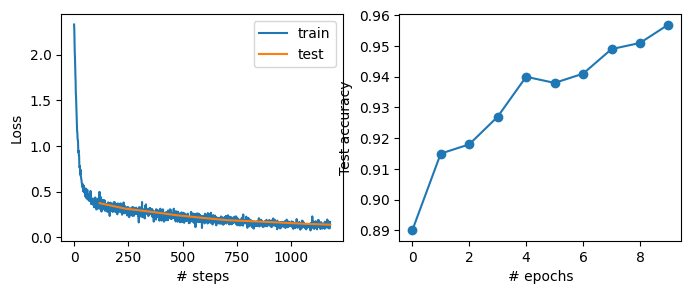

In [51]:
train(model, device=device, num_epochs=10);

### Alternative way to define neuralnetwork configuration is **nn.Module**

In [52]:
# Alternate method to define the same model as previous one
class Net(nn.Module):  
    def __init__(self): 
        # constructor : defining all objects and methods 
        super(Net, self).__init__() # In order to have access to parants methods and objects
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)
 
    def forward(self, X):
        Xf = X.flatten(1) # adding flatten here
        X1 = F.relu(self.fc1(Xf))  # first dense layer
        return self.fc2(X1) # second layer without activator 

In [53]:
model2 = Net().to(device)

Accuracy:  tensor(0.9050, device='cuda:0', dtype=torch.float64)


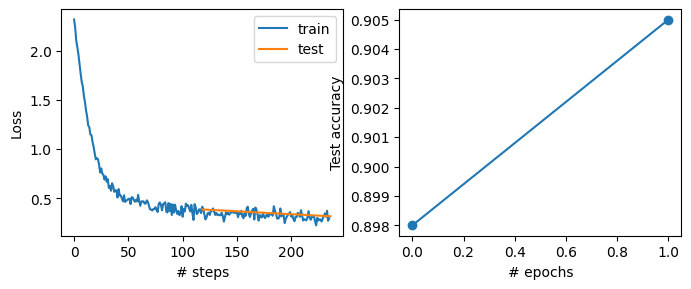

([2.3209893703460693,
  2.240245819091797,
  2.104008436203003,
  2.039815664291382,
  1.964576244354248,
  1.8687013387680054,
  1.7740676403045654,
  1.6869879961013794,
  1.6406453847885132,
  1.5456697940826416,
  1.481011986732483,
  1.3951705694198608,
  1.3320481777191162,
  1.2413756847381592,
  1.2244597673416138,
  1.1496000289916992,
  1.1427839994430542,
  1.0738953351974487,
  1.0230873823165894,
  0.9560750722885132,
  0.8963441252708435,
  0.9089422225952148,
  0.896700918674469,
  0.8418726325035095,
  0.7611133456230164,
  0.8039080500602722,
  0.7500115036964417,
  0.7385739088058472,
  0.6901008486747742,
  0.7235240340232849,
  0.669330894947052,
  0.6956644654273987,
  0.6051958203315735,
  0.6262341737747192,
  0.5762669444084167,
  0.6528012752532959,
  0.6229494214057922,
  0.5652227997779846,
  0.5822997689247131,
  0.5765084624290466,
  0.5073914527893066,
  0.5934221148490906,
  0.5290190577507019,
  0.5272218585014343,
  0.5017444491386414,
  0.4681880176067

In [54]:
train(model2, num_epochs=2, device=device)

In [55]:
for i in range(3):
    print(model2[i])

TypeError: 'Net' object is not subscriptable

In [ ]:
model.parameters()